In [36]:
library(sf)
library(tmap)
library(tmaptools)
library(dplyr)
library(lubridate)
library(ggplot2)
library(gstat)
library(sp)

In [37]:
# Read the census shapefile
census <- st_read(dsn="./data/nyc2020_census/nyct2020.shp", layer="nyct2020")

# Load the population csv data
population <- read.csv("./data/nyc_censusdata_2020.csv")
population$BCT2020 <- as.character(population$BCT2020)

# Join population data to census data
census_joined <- census %>%
  left_join(population, by= c("Borjan2020"="BCT2020"))

# Plot census polygons
plot(census_joined["CT2020"])

# Load Citibike data
citibike_jan <- read.csv("./data/2019-citibike-tripdata/1_January/201901-citibike-tripdata_1.csv")

Reading layer `nyct2020' from data source 
  `/Users/jiazhuangfeng/Documents/project/spatial_analysis/assignment/data/nyc2020_census/nyct2020.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 2325 features and 14 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 913175.1 ymin: 120128.4 xmax: 1067383 ymax: 272844.3
Projected CRS: NAD83 / New York Long Island (ftUS)


ERROR: [1m[33mError[39m in `sf_column %in% names(g)`:[22m
[1m[22m[33m![39m Join columns in `x` must be present in the data.
[31m✖[39m Problem with `Borjan2020`.


In [4]:
# Convert starttime and stoptime into DateTime format
citibike_jan$starttime <- ymd_hms(citibike_jan$starttime)
citibike_jan$stoptime <- ymd_hms(citibike_jan$stoptime)

# Cleaning up for weekday/weekend and hour information
citibike_jan <- citibike_jan %>%
  mutate(
    # Weekday or weekend
    is_weekend = ifelse(wday(starttime) %in% c(1,7), TRUE, FALSE),
    # Start time hour
    start_hour = hour(starttime)
  )

In [5]:
# Create the station dataset with attributes on station id/lat/long, ride counts, user counts and time-based counts
start_station_jan <- citibike_jan %>%
  # Group by start.station and user type
  group_by(start.station.id, start.station.latitude, start.station.longitude) %>%
  summarise(
    ride_start_count = n(),
    usertype_subscriber_count = sum(usertype == "Subscriber"),
    usertype_customer_count = sum(usertype == "Customer"),
    
    # Weekday counts for time intervals AM/PM Peak/Off-Peak - ref Liu et al
    ride_start_weekday_7_10 = sum(!is_weekend & start_hour>=7 & start_hour<10),
    ride_start_weekday_10_17 = sum(!is_weekend & start_hour>=10 & start_hour<17),
    ride_start_weekday_17_0 = sum(!is_weekend & start_hour>=17 & start_hour<24),
    ride_start_weekday_0_7 = sum(!is_weekend & start_hour>=0 & start_hour<7),
    
    # Weekend counts for leisure/others - ref Liu et al
    ride_start_weekend_10_0 = sum(is_weekend & start_hour>=10 & start_hour<24),
    ride_start_weekend_0_10 = sum(is_weekend & start_hour>=0 & start_hour<10)
  ) %>%
  rename(
    station_id = start.station.id,
    station_latitude = start.station.latitude,
    station_longitude = start.station.longitude
  )

# Calculate end station counts  
end_station_jan <- citibike_jan %>%
  group_by(end.station.id, end.station.latitude, end.station.longitude) %>%
  summarise(
    ride_end_count = n()
  ) %>%
  rename(
    station_id = end.station.id,
    station_latitude = end.station.latitude,
    station_longitude = end.station.longitude
  )

# Combine start and end to return ride activity by station
station_jan <- full_join(start_station_jan, end_station_jan,
                          by= c("station_id", "station_latitude", "station_longitude")) %>%
  # Deal with NA values
  mutate(
    ride_start_count = ifelse(is.na(ride_start_count), 0, ride_start_count),
    ride_end_count = ifelse(is.na(ride_end_count), 0, ride_end_count),
    ride_activity = ride_start_count + ride_end_count
  )

# Add median trip duration for start stations
start_station_duration <- citibike_jan %>%
  group_by(start.station.id) %>%
  summarise(median_trip_duration_start = median(tripduration, na.rm=TRUE)) %>%
  rename(station_id = start.station.id)

# Add median trip duration for end stations
end_station_duration <- citibike_jan %>%
  group_by(end.station.id) %>%
  summarise(median_trip_duration_end = median(tripduration, na.rm=TRUE)) %>%
  rename(station_id = end.station.id)

# Merge median trip duration with station_july
station_jan <- station_jan %>%
  left_join(start_station_duration, by= "station_id") %>%
  left_join(end_station_duration, by= "station_id")

`summarise()` has grouped output by 'start.station.id', 'start.station.latitude'. You
can override using the `.groups` argument.
`summarise()` has grouped output by 'end.station.id', 'end.station.latitude'. You can
override using the `.groups` argument.


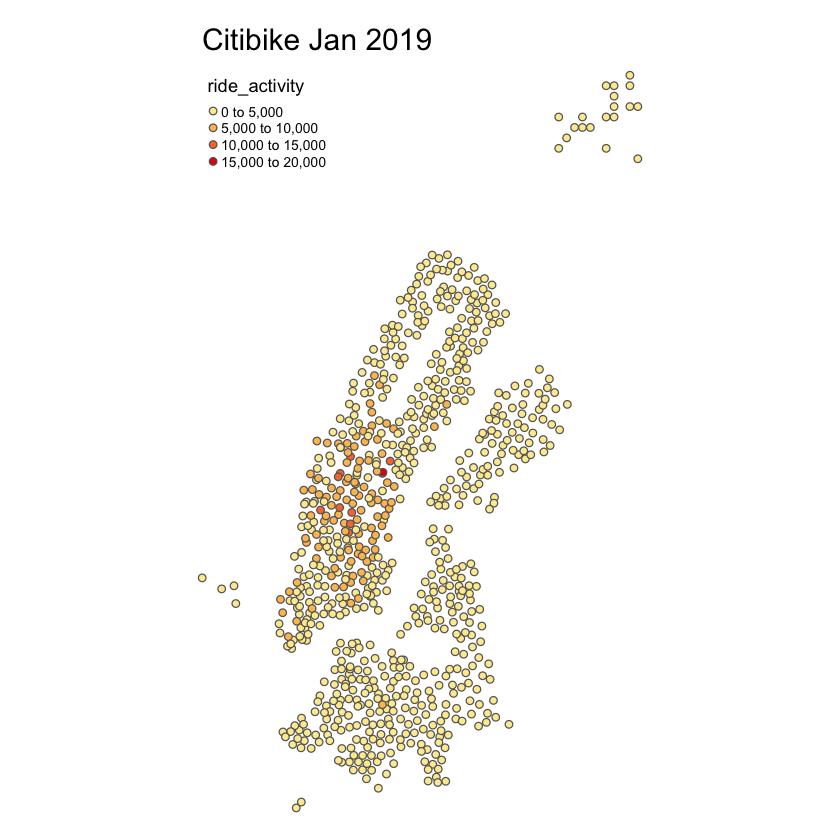

In [6]:
# Convert cleaned July dataset into sf object
station_jan_sf <- station_jan %>%
  st_as_sf(coords = c("station_longitude", "station_latitude"), crs=4326, remove=FALSE)

# Plot map of points
tm_shape(station_jan_sf) +
  tm_bubbles(size=0.1, col="ride_activity", palette="YlOrRd") +
  tm_layout(main.title = "Citibike Jan 2019",
            main.title.size=1.5, frame=FALSE, legend.position = c("left", "top"))

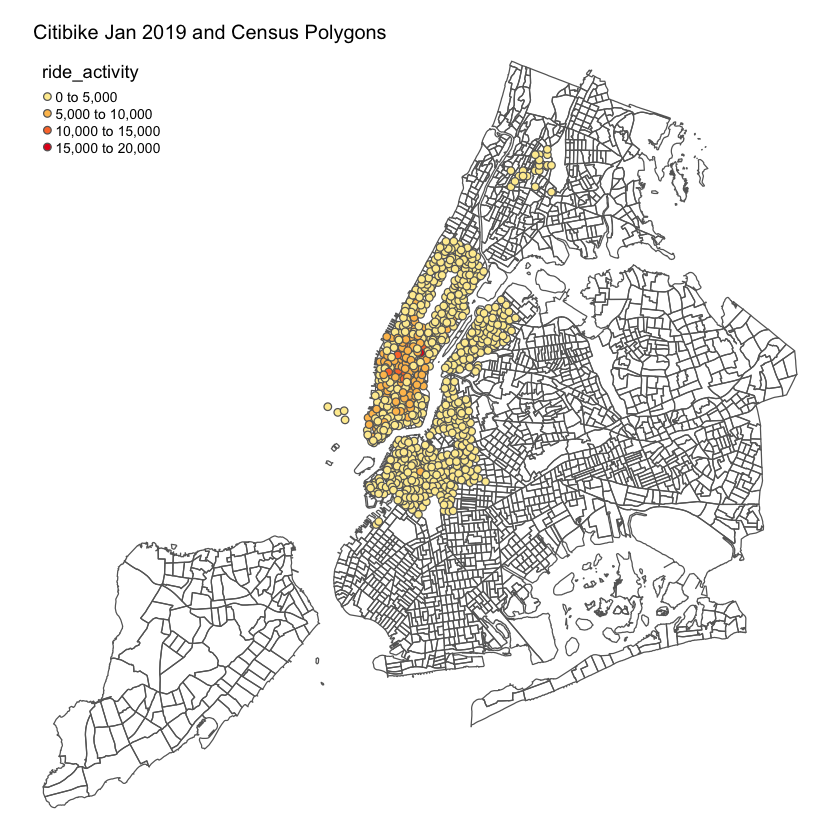

In [7]:
# Convert Census polygon crs4269 to crs4329
census_joined <- st_transform(census_joined, crs=st_crs(station_jan_sf))

# Plot interim data
tm_shape(census) +
  tm_borders() +
  tm_shape(station_jan_sf) +
  tm_bubbles(size=0.1, col="ride_activity", palette="YlOrRd") + 
  tm_layout(main.title = "Citibike Jan 2019 and Census Polygons",
            main.title.size=1, frame=FALSE, legend.position= c("left", "top"))

In [8]:
# Creating an aggregated station dataset at census tract level
station_jan_nyc <- station_jan_sf %>%
  # Left join to remove stations outside NYC (do not have census tract)
  st_join(census_joined, join= st_within, left=FALSE)
ct_station_jan <- station_jan_nyc %>%
  group_by(Borjan2020) %>%
  summarise(
    num_stations = n(),
    total_ride_start_count = sum(ride_start_count, na.rm=TRUE),
    total_ride_end_count = sum(ride_end_count, na.rm=TRUE),
    total_ride_activity = sum(ride_activity, na.rm=TRUE),
    median_trip_duration_start = median(median_trip_duration_start, na.rm=TRUE),
    median_trip_duration_end = median(median_trip_duration_end, na.rm=TRUE),
    usertype_subscriber_count = sum(usertype_subscriber_count, na.rm=TRUE),
    usertype_customer_count = sum(usertype_customer_count, na.rm=TRUE),
    # Adding in the time factor
    weekday_7_10 = sum(ride_start_weekday_7_10, na.rm=TRUE),
    weekday_10_17 = sum(ride_start_weekday_10_17, na.rm=TRUE),
    weekday_17_0 = sum(ride_start_weekday_17_0, na.rm=TRUE),
    weekday_0_7 = sum(ride_start_weekday_0_7, na.rm=TRUE),
    weekend_10_0 = sum(ride_start_weekend_10_0, na.rm=TRUE),
    weekend_0_10 = sum(ride_start_weekend_0_10, na.rm=TRUE)
  )

# Converting to df to allow for inner join and drop column for polygons without Citibike docks
ct_station_jan_df <- as.data.frame(ct_station_jan)
agg_citibike_jan <- census_joined %>%
  inner_join(ct_station_jan_df, by= "Borjan2020")

# colnames(agg_citibike_jan)
# agg_citibike_jan <- agg_citibike_jan_copy

# List of columns to convert from character to integer
columns_to_convert <- c("Pop1", "PopU5", "Pop5t9", "Pop10t14", "Pop15t19", "Pop20t24", "Pop25t29", "Pop30t34", "Pop35t39", "PopU18", "Pop65pl", "GQClgHsg", "Fam", "HUnits")
# Note: chr values with comma (e.g. "3,512") automatically converts to NA -- therefore need to remove the comma
agg_citibike_jan[columns_to_convert] <- lapply(agg_citibike_jan[columns_to_convert], function(x) {
  x <- gsub(",", "", x)             # Remove commas
  x <- as.numeric(x)                # Convert to numeric
  x[is.na(x)] <- 0                  # Replace NAs with 0
  return(x)
})

Warning message in FUN(X[[i]], ...):
“强制改变过程中产生了NA”
Warning message in `[<-.data.frame`(`*tmp*`, columns_to_convert, value = list(Pop1 = c(11616, :
“提供了15变量用来替换14变量”


In [9]:
# Replace NA with 0 for all numeric and integer columns
agg_citibike_jan[sapply(agg_citibike_jan, is.numeric)] <- 
  lapply(agg_citibike_jan[sapply(agg_citibike_jan, is.numeric)], function(x) {
    x[is.na(x)] <- 0
    return(x)
  })

Warning message in `[<-.data.frame`(`*tmp*`, sapply(agg_citibike_jan, is.numeric), :
“提供了48变量用来替换47变量”


In [10]:
# Verify if there are any remaining NAs
sum(is.na(agg_citibike_jan))

[1] 416

In [11]:
# Create a new column 'Pop19t64' as Pop1 - PopU18 - Pop65pl
agg_citibike_jan$Pop19t64 <- agg_citibike_jan$Pop1 - agg_citibike_jan$PopU18 - agg_citibike_jan$Pop65pl

# Verify the result
head(agg_citibike_jan[, c("Pop1", "PopU18", "Pop65pl", "Pop19t64")])

Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson



,Pop1,PopU18,Pop65pl,Pop19t64,geometry.x
,<dbl>,<dbl>,<dbl>,<dbl>,<MULTIPOLYGON [°]>
1,11616,1723,3019,6874,MULTIPOLYGON (((-73.99022 4...
2,3543,679,784,2080,MULTIPOLYGON (((-73.98837 4...
3,7934,845,1201,5888,MULTIPOLYGON (((-73.98985 4...
4,6969,878,1333,4758,MULTIPOLYGON (((-73.97875 4...
5,3609,489,488,2632,MULTIPOLYGON (((-73.97689 4...
6,6819,829,1342,4648,MULTIPOLYGON (((-73.9733 40...


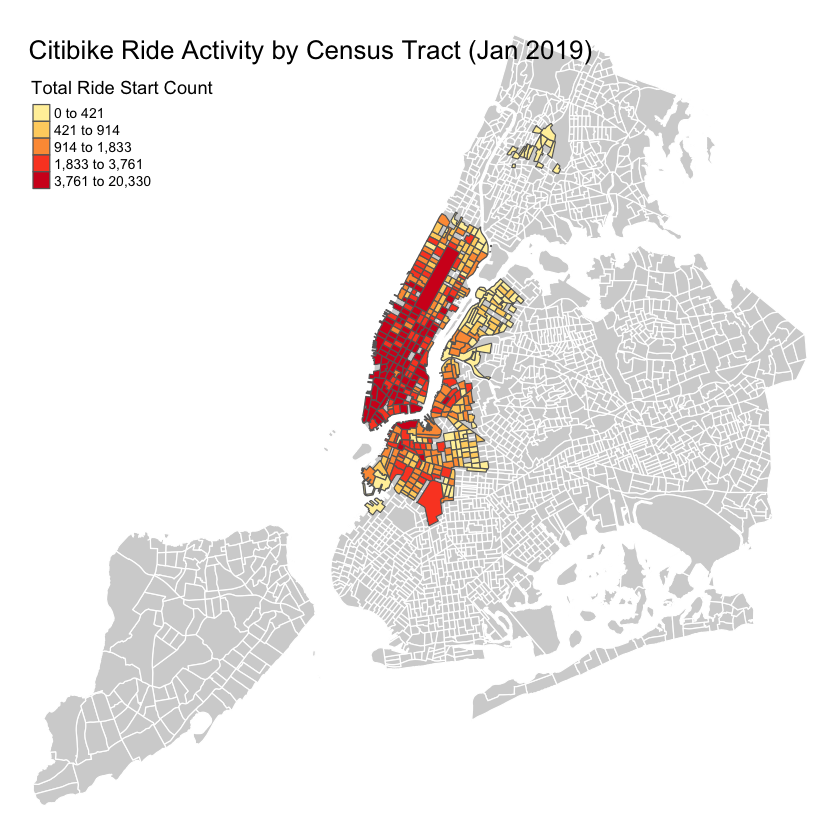

In [12]:
# Plotting the map with context
tm_shape(census_joined)+
  tm_borders(col= "white")+
  tm_fill(col= "lightgrey")+
  tm_shape(agg_citibike_jan)+
  tm_polygons(col= "total_ride_start_count",
              style= "quantile",
              palette= "YlOrRd",
              title= "Total Ride Start Count")+
  tm_layout(title= "Citibike Ride Activity by Census Tract (Jan 2019)",
            title.position= c("left", "top"),
            legend.position= c("left", "top"),
            legend.outside= FALSE,
            frame= FALSE)

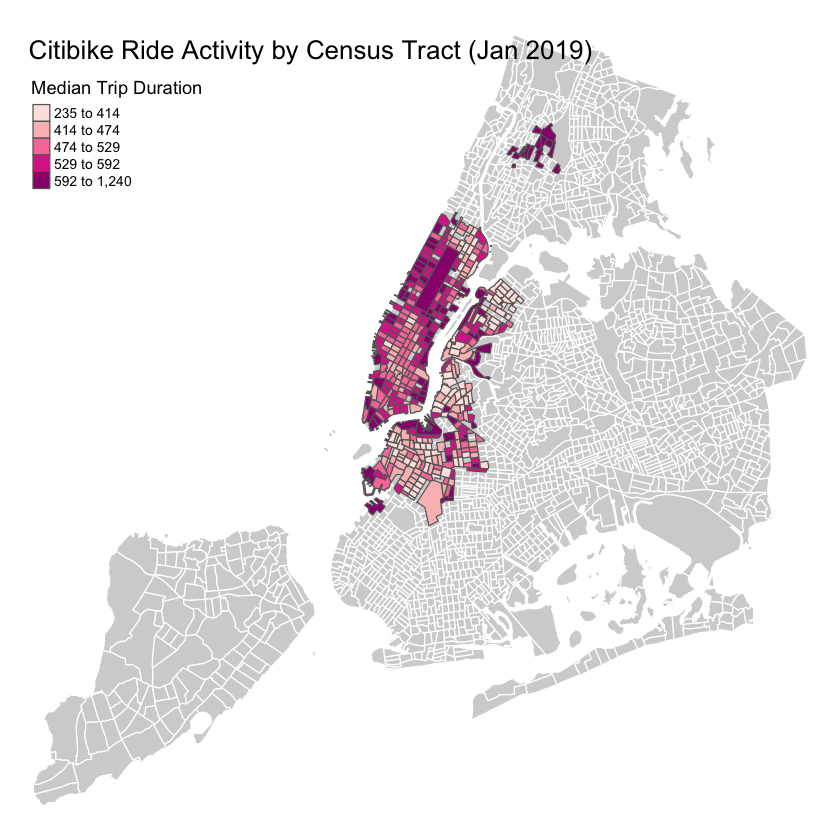

In [13]:
# Plotting the map with context
tm_shape(census_joined)+
  tm_borders(col= "white")+
  tm_fill(col= "lightgrey")+
  tm_shape(agg_citibike_jan)+
  tm_polygons(col= "median_trip_duration_start",
              style= "quantile",
              palette= "RdPu",
              title= "Median Trip Duration")+
  tm_layout(title= "Citibike Ride Activity by Census Tract (Jan 2019)",
            title.position= c("left", "top"),
            legend.position= c("left", "top"),
            legend.outside= FALSE,
            frame= FALSE)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


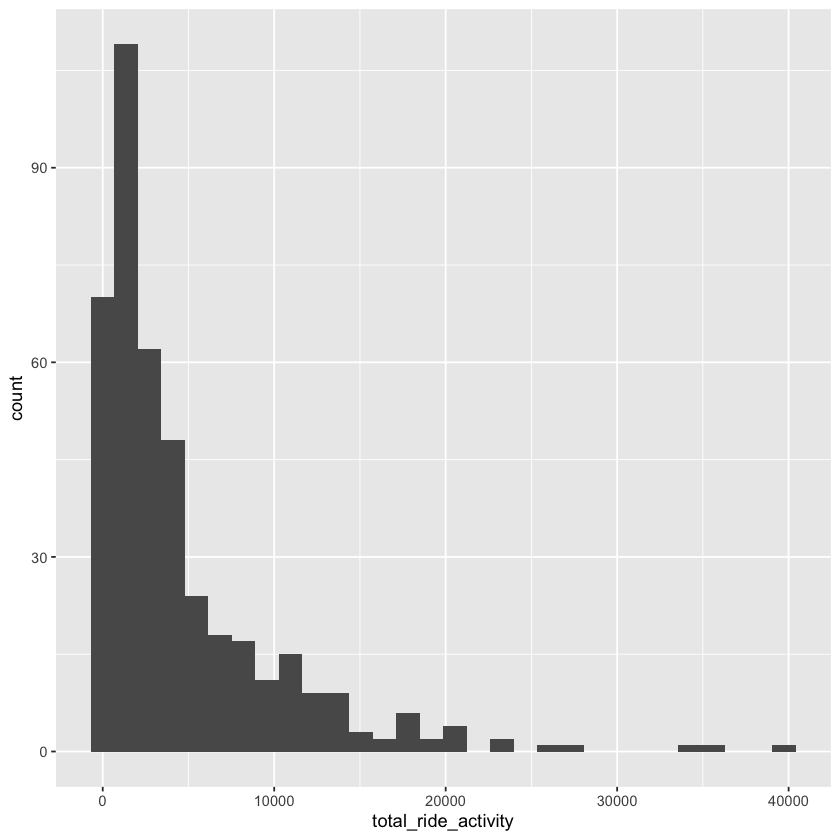

In [14]:
# Plot histogram
ggplot(data=agg_citibike_jan, aes(total_ride_activity)) + geom_histogram()

Variable(s) "lm.res" contains positive and negative values, so midpoint is set to 0. Set midpoint = NA to show the full spectrum of the color palette.



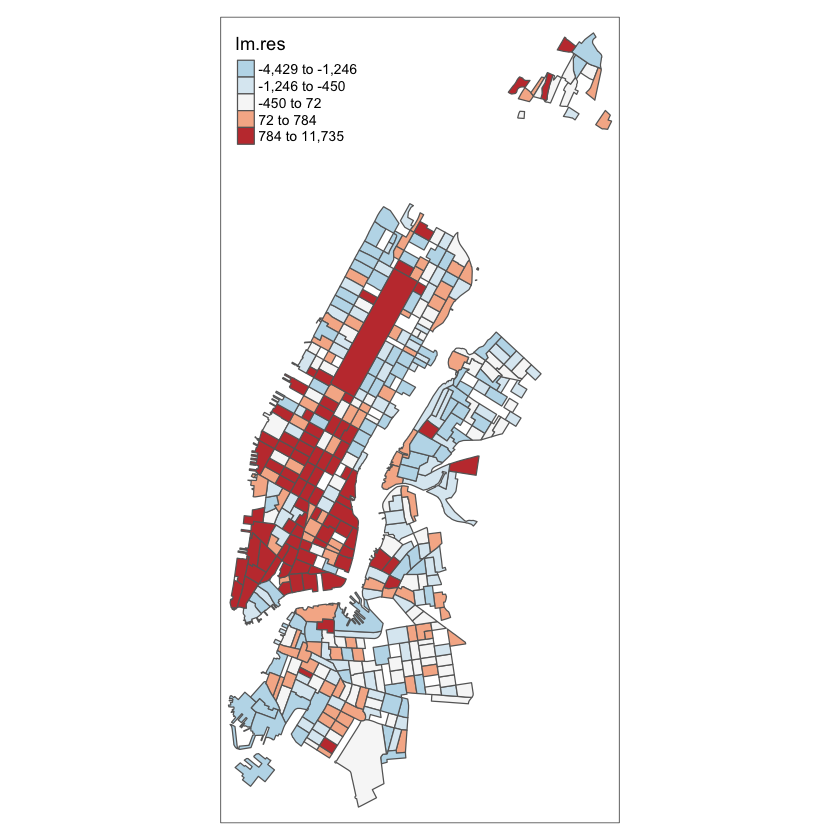

In [15]:
# Testing for spatial autocorrelation in regression errors
janbike.lm <- lm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + HUnits + Fam + AvgHHSz + GQClgHsg + Shape_Area + num_stations, data=agg_citibike_jan)
# Saving the residuals as a column
agg_citibike_jan$lm.res <- residuals(janbike.lm)
# Plotting the residuals
tm_shape(agg_citibike_jan)+tm_polygons('lm.res', palette='-RdBu', style='quantile')

In [24]:
library(spdep)
library(knitr)
nb <- poly2nb(agg_citibike_jan)
W <- nb2mat(nb, style='W', zero.policy = TRUE)
colnames(W) <- rownames(W)
NbrL <- dnearneigh(st_centroid(agg_citibike_jan), 0, 1.6)
# Creating a weights list
Wl <- nb2listw(nb, zero.policy = TRUE)
moran(agg_citibike_jan$total_ride_start_count, Wl, n=length(Wl$neighbours), S0=Szero(Wl))

# Creating a list of neighbours not including self
D <- nb2listw(NbrL, style='B')
# Creating a list of neighbours, but include self
D_star <- nb2listw(include.self(NbrL), style='B')

G <- globalG.test(agg_citibike_jan$total_ride_start_count, D)
G <- globalG.test(agg_citibike_jan$total_ride_start_count, D_star)

# Check if there are any isolated observations (no neighbors) by returning the length (number of neighbours) for each polygon
sapply(NbrL, length)

Warning message in poly2nb(agg_citibike_jan):
“some observations have no neighbours;
if this seems unexpected, try increasing the snap argument.”
Warning message in poly2nb(agg_citibike_jan):
“neighbour object has 6 sub-graphs;
if this sub-graph count seems unexpected, try increasing the snap argument.”
Warning message:
“st_centroid assumes attributes are constant over geometries”
Warning message in dnearneigh(st_centroid(agg_citibike_jan), 0, 1.6):
“neighbour object has 2 sub-graphs”


$I
[1] 0.4743091

$K
[1] 11.69548

[1] 29 31 39 33 32 32 29 39 28 37 45 48 26 23 41 45 39 44 41 42 41 42 47 44 40
 [26] 38 32 31 37 33 33 43 31 32 34 37 41 28 42 38 28 39 36 29 40 42 41 33 24 32
 [51] 40 38 39 32 41 40 37 31 43 29 28 43 28 35 33 33 42 31 33 33 40 32 26 30 22
 [76] 24 29 27 28 27 29 24 23 27 25 23 27 21 26 17 28 21 31 17 21 26 21 32 34 18
[101] 26 23 19 18 21 22 22 17 19 34 33 26 22  7  9  6 12 13 11 17 21 21 24 25 27
[126] 25 21 23 28 27 23 28 30 28 23 21 20 18 15 16 16 13 18 20 15 20 11 10  3 42
[151] 20 41 33 39 20 25 29 30 35 31 20  9  6 10 18 10 23 20 20 25 38 31 30 27 31
[176] 14 29 18 22 29 28 27 27 31 16 14 40 45 47 42 28 30 35 36 29 27 25 28 29 28
[201] 30 32 34 41 28 24 17 15 25 25 28 12 32 43 40 20 29 19 16 22 17 18 24 20 22
[226] 33 18 19 26 26 26 28 26 38 40 37 41 40 40 43 45 38 30 24  6 25 27 37 36 44
[251] 13 36 26 45 44 40 40 35 29 22 17 15 15 22 26 31 37 36 37 37 38 35 31 30 36
[276] 40 39 35 36 34 32 25 16 21 18 25 31 35 36 31 31 32 30 33 30 28 29 30 27 28
[301] 29 28 23 13 15 19 24 26 28 25 20 10 27 10 13 19 22 23 23 24 28 25 26 28 29
[326] 28 25 26 25 25 29 30 20 23 28 27 15 21 16 18 31 31 36 29 24 19 28 31 21 22
[351] 14 25 16 30 24 25 24 18 27 27  8 19 29 27 17 17 30 35 24 31 31 12 31 14 10
[376] 24 32 33 25 17 22 25 26 13 13 32 30 24 21 14 31 35 11 11 12 25 20 18 24 27
[401] 25 28 14 21 18 18 19 17 16  1 45 44 32 33 33 34

In [25]:
# Load regression libraries
library(spgwr)
library(spatialreg)

# Spatial Lag Regression
janbike.lag <- lagsarlm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + HUnits + Fam + AvgHHSz + GQClgHsg + Shape_Area + num_stations, data=agg_citibike_jan, listw=D)

Warning message in lagsarlm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=2.39674e-20 - using numerical Hessian.”
Warning message in sqrt(diag(fdHess)[-1]):
“产生了NaNs”


In [27]:
summary(janbike.lag)


Call:lagsarlm(formula = total_ride_start_count ~ PopU18 + Pop19t64 + 
    Pop65pl + HUnits + Fam + AvgHHSz + GQClgHsg + Shape_Area + 
    num_stations, data = agg_citibike_jan, listw = D)

Residuals:
     Min       1Q   Median       3Q      Max 
-3681.96  -670.06    37.82   635.87  9969.37 

Type: lag 
Coefficients: (numerical Hessian approximate standard errors) 
                Estimate  Std. Error z value  Pr(>|z|)
(Intercept)  -2.5150e+03  5.9088e+02 -4.2563 2.078e-05
PopU18        9.1995e-02  4.4801e-01  0.2053  0.837307
Pop19t64     -1.3586e-01  8.8707e-02 -1.5315  0.125640
Pop65pl      -4.2706e-01  2.7530e-01 -1.5513  0.120837
HUnits        5.4746e-01  1.8049e-01  3.0331  0.002421
Fam          -2.8655e-01  6.9216e-01 -0.4140  0.678876
AvgHHSz       1.8653e+02  2.4386e+02  0.7649  0.444325
GQClgHsg      1.4038e-02         NaN     NaN       NaN
Shape_Area    3.9809e-05  3.7186e-05  1.0705  0.284377
num_stations  1.2015e+03  7.4877e+01 16.0469 < 2.2e-16

Rho: 0.0227, LR test value

In [29]:
library(spgwr)
library(spatialreg)

# 设置 K 折交叉验证的参数
set.seed(123)
k <- 5
n <- nrow(agg_citibike_jan)
folds <- sample(1:k, n, replace = TRUE)

# 初始化存储误差的列表
mse_list <- c()
rmse_list <- c()

# 进行 K 折交叉验证
for (i in 1:k) {
  # 划分训练集和测试集
  train_data <- agg_citibike_jan[folds != i, ]
  test_data <- agg_citibike_jan[folds == i, ]
  
  # 提取训练集的空间权重矩阵
  train_D <- subset(D, folds != i)  # 子集化权重矩阵
  
  # 拟合 Spatial Lag 回归模型（允许孤立点）
  model <- lagsarlm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + HUnits + 
                      Fam + AvgHHSz + GQClgHsg + Shape_Area + num_stations, 
                    data = train_data, listw = train_D, zero.policy = TRUE)
  
  # 在测试集上进行预测（允许孤立点）
  predicted <- predict(model, newdata = test_data, listw = D, zero.policy = TRUE)
  actual <- test_data$total_ride_start_count
  
  # 计算误差
  mse <- mean((predicted - actual)^2)
  rmse <- sqrt(mse)
  
  # 存储误差
  mse_list <- c(mse_list, mse)
  rmse_list <- c(rmse_list, rmse)
}

# 计算平均误差
mean_mse <- mean(mse_list)
mean_rmse <- mean(rmse_list)

# 输出结果
cat("K 折交叉验证结果：\n")
cat("平均 MSE:", mean_mse, "\n")
cat("平均 RMSE:", mean_rmse, "\n")


Warning message in lagsarlm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=2.05158e-20 - using numerical Hessian.”
Warning message in subset.nb(x = nb, subset = subset):
“subsetting caused increase in subgraph count”
Warning message in lagsarlm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for tol.solve = 2.22044604925031e-16 
  倒条件数=3.5819e-20 - using numerical Hessian.”
Warning message in subset.nb(x = nb, subset = subset):
“subsetting caused increase in subgraph count”
Warning message in subset.nb(x = nb, subset = subset):
“subsetting caused increase in subgraph count”
Warning message in subset.listw(D, folds != i):
“subsetting created no-neighbour observations, zero.policy set TRUE”
Warning message in lagsarlm(total_ride_start_count ~ PopU18 + Pop19t64 + Pop65pl + :
“inversion of asymptotic covariance matrix failed for

K 折交叉验证结果：
平均 MSE: 7007507 
平均 RMSE: 2643.795 


In [31]:
write.csv(agg_citibike_jan, "agg_citibike_jan.csv", row.names = FALSE)

In [38]:
# 提取 CT2020 列并保存为数据框
ct2020_df <- data.frame(CT2020 = agg_citibike_jan$BoroCT2020)

# 保存为 CSV 文件
write.csv(ct2020_df, "BoroCT2020_01.csv", row.names = FALSE)

# 提示保存成功
cat("CT2020 列已保存为 CT2020.csv 文件。\n")


CT2020 列已保存为 CT2020.csv 文件。


In [35]:
agg_citibike_jan$Pop19t64

[1]  6874  2080  5888  4758  2632  4648  2568  6496  4352  5944  2574  2504
 [13]  2248  4475  3121  4524  5496  3263   744  2822  3476  3185  1461  4238
 [25]  4571  5600  4423  3356  4375  7651  4894  2461  4621  7110  4335  6024
 [37]  2543  2865  1692  5220  4542  5878  1546  6258    79  3320   557  3061
 [49]  3259  1704  2108   154   642  2282   365   853   265   905   194  1530
 [61]  6264   982  1970  2861  3456  1582  2435  4254  5965  1786  3013  5616
 [73]  3795  2594  2285  4008  3993  3396  3397  4371  1463  7500  4557  5577
 [85]  4706  4211  4858  5706  5001  5838  3732  5459  3403  6547  5351  5040
 [97]  5344  5038  3260  5947  6116  2369  6969  3987  2658  2590  3792  4140
[109]  2659  6122  4666  2421  4873  1120  2980  3668  1118  2381  2262  3368
[121]  1812  1681  1392  1914  2606  4178  1032  3297  4724  2901  3705  3441
[133]  3531  1660  2617  1460  1822  2726  1892  1888  2932  1357  2959  1873
[145]  1639  1277   114   289  3331  7496  9109  5290 12362  6731  2844  3253
[157]  7669  3173  5062  2230  1359  3313  3923  4836  3446  3489  1623    30
[169]  6242  7173  4902  7753  5401  3483  3044  3037  2792  3431  1684  3532
[181]  6425  4810  1573  2401  9219  1593  4025  3888  4266  3855  3907  3369
[193]  1931  3455  8224  5444  9065  4705  2816  3581  4753  2153  2074  2217
[205]  5144  3891  5956  5833  2993  1026  2955  3290  9240  3157  4901  1956
[217]  2529  4279    18  4273  2672  1189  4205  2039  4073  3253  5980  4540
[229]  2911  2429  3066  1839  3087  5079  2347     0  3837  1859  3937  1954
[241]  2411  2886  2479  1323  1541  3752  2370  1202  1424  2737  3918  1187
[253]  1470  2886  1795  2599  2989  3107  2592  2412  2730  1101  2470  1769
[265]  2233  2893  3480  2509  2996  2432  3153  2061  2781  1013  4673  2558
[277]  3089  2956  1582  2574  3428  1877  2770  3142  3310  3111  3463  3090
[289]  4042  2275  3300  3255  3231  2939  2597  3049  1826  1716  2153  5017
[301]  1551  3272  2260  2484  2268  3093  3030  2647  3580   530  2239  2728
[313]  5643  2453  4251  3600  2247  4109  2604  2595  2264  3314  1640  2356
[325]  3308  4615  2257  5342  4039  2093  4470  2081  4688  3527  2477  1565
[337]  3990  3383  4022  3012  3594   108  3235  4011  2244  5752  3937  6614
[349]  1353  1743  1379  1071  3657  1796  4448  6522     3  2035  4126  4475
[361]  2228  7986  6625  2778  1440  1171  3851   712  5905   817  2727     7
[373]  2649  7447    68  2057  3691  5346     1  2518  1712  2348  2082  4159
[385]  4411  2592  3006  3084  2113  1102  6091  6576  2330  2701  7261  2470
[397]  4629  2729  5057  7185  1391  3392  4669  5338  5710  5380  2726  2968
[409]     0     0  4632  1997  3910  1931  3874  1368